In [21]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from scipy.optimize import root
from sympy import Eq, S, solve, symbols


def p_x_given_theta(x: npt.ArrayLike, theta: float) -> npt.ArrayLike:
    """The probability density function.

    Args:
        x (numpy.typing.ArrayLike): The value(s) at which to evaluate the density function.
        theta (float): The theta parameter of the distribution.

    Returns:
        numpy.typing.ArrayLike: The value of the density function at x.
    """
    x = np.asarray(x)
    return (1. / np.pi) * (1. / (1. + (x - theta)**2))


def log_likelihood(theta: float, data: npt.ArrayLike) -> float:
    """The log-likelihood function for the PDF given in the instructions.

    Args:
        theta (float): The theta parameter of the distribution.
        data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.

    Returns:
        float: The log-likelihood of the data given the theta parameter.
    """
    data = np.asarray(data)
    return np.sum([np.log(p_x_given_theta(data, theta))])


def log_likelihood_derivative(theta: float, data: npt.ArrayLike) -> float:
    """The derivative of the log-likelihood function for the PDF given in the instructions.

    Args:
        theta (float): The theta parameter of the distribution.
        data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
    
    Returns:
        float: The derivative of the log-likelihood of the data given the theta parameter.
    """
    return np.sum([2 * (data - theta) / (1 + (data - theta)**2)])


def plot_log_likelihood(d1: npt.ArrayLike, d2: npt.ArrayLike, theta: npt.ArrayLike) -> None:
    """Plot the log-likelihood functions for the two datasets.

    Args:
        d1 (numpy.typing.ArrayLike): The first dataset.
        d2 (numpy.typing.ArrayLike): The second dataset.
        theta (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
    """
    # Compute the log-likelihood for each value of theta
    log_likelihoods_1 = [log_likelihood(t, d1) for t in theta]
    log_likelihoods_2 = [log_likelihood(t, d2) for t in theta]

    # Plot the log-likelihood functions
    plt.figure()
    plt.plot(theta, log_likelihoods_1, label="D1")
    plt.plot(theta, log_likelihoods_2, label="D2")
    plt.xlabel("Theta")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.show()


def plot_log_likelihood_derivative(d1: npt.ArrayLike, d2: npt.ArrayLike, theta: npt.ArrayLike) -> None:
    """Plot the derivative of the log-likelihood functions for the two datasets.

    Args:
        d1 (numpy.typing.ArrayLike): The first dataset.
        d2 (numpy.typing.ArrayLike): The second dataset.
        theta (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
    """
    # Plot the log-likelihood derivative
    plt.figure()
    plt.plot(theta, [log_likelihood_derivative(t, d1) for t in theta], label="D1")
    plt.plot(theta, [log_likelihood_derivative(t, d2) for t in theta], label="D2")
    plt.xlabel("Theta")
    plt.ylabel("Log-likelihood derivative")
    plt.legend()
    plt.show()


class Classifier:
    """The classifier for the PDF given in the instructions.

    The classifier is tailored to work only with the PDF given in the instructions.

    functions:
        fit: Fit the classifier to the two datasets.
    
    Example:
        d1 = np.random.uniform(-10, 10, 100)
        d2 = np.random.uniform(-10, 10, 100)
        # Fit the classifier to the datasets
        classifier = Classifier()
        theta_1, theta_2 = classifier.fit(d1, d2)
    """

    def __init__(self):
        pass

    def fit(
        self,
        d_1: npt.ArrayLike,
        d_2: npt.ArrayLike,
        solve_method: str = 'numeric',
        thetas: npt.ArrayLike = None
    ) -> Tuple[float, float]:
        """Fit the classifier to the two datasets.

        The classifier is fitted by finding the optimal theta parameter for each dataset.

        Args:
            d_1 (numpy.typing.ArrayLike): The first dataset.
            d_2 (numpy.typing.ArrayLike): The second dataset.
            solve_method (str, optional): The method to use for solving the log-likelihood derivative equation.
                Can be "numeric", "symbolic" or "evaluating". Defaults to "numeric".
                - "numeric": Uses the scipy.optimize.root function to find the root of the derivative.
                - "symbolic": Solves the derivative equation symbolically.
                - "evaluating": Evaluates the log-likelihood function for all thetas given.
            thetas (numpy.typing.ArrayLike, optional): The values of theta to evaluate the log-likelihood functions on.
                Used only if the solve_method is "evaluating". Defaults to None.

        Returns:
            Tuple[float, float]: The optimal theta parameters for the two datasets.
        """
        if solve_method == 'numeric':
            # The optimal thetas are found by solving the derivative of the log-likelihood function.
            # The starting points are chosen by examining the derivative plot first.
            # The symbolic solution is also available, that finds all the roots without needing a starting point,
            # but it is slow.
            theta_1 = self._solve_by_numeric_method(d_1, starting_point=2.5) # Starting point is set to 2.5 after examining the derivative plot
            theta_2 = self._solve_by_numeric_method(d_2, starting_point=-2.5) # Starting point is set to -2.5 after examining the derivative plot
        elif solve_method == 'symbolic':
            theta_1 = self._solve_by_symbolic_method(d_1)
            theta_2 = self._solve_by_symbolic_method(d_2)
        elif solve_method == 'evaluating':
            theta_1 = self._solve_by_evaluating_thetas(d_1, thetas)
            theta_2 = self._solve_by_evaluating_thetas(d_2, thetas)
        else:
            raise ValueError("Invalid solve method. Use 'numeric', 'symbolic' or 'evaluating'.")
        
        return theta_1, theta_2
    
    def predict(
        self,
        data: npt.ArrayLike,
        theta_1: float,
        theta_2: float,
        prior_1: float,
        prior_2:float
    ) -> npt.ArrayLike:
        """Predict the class of the data.

        The class is predicted by choosing the class with the highest log-likelihood.

        Args:
            data (numpy.typing.ArrayLike): The data to predict the class of.
            theta_1 (float): The optimal theta parameter for the first dataset.
            theta_2 (float): The optimal theta parameter for the second dataset.

        Returns:
            numpy.typing.ArrayLike: The class of the data
        """
        def g(x: npt.ArrayLike) -> npt.ArrayLike:
            return (
                np.log(p_x_given_theta(x, theta_1))
                - np.log(p_x_given_theta(x, theta_2))
                + prior_1
                - prior_2
            )
        
        return g(data)

    @staticmethod
    def _solve_by_symbolic_method(data: npt.ArrayLike) -> float:
        """Solve the log-likelihood derivative equation symbolically.

        Finds all the real roots of the derivative of the log-likelihood function.
        Pretty slow.
        
        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        # Define the symbolic variables and function
        theta = symbols('theta')

        f_prime = sum(2 * (x - theta) / (1 + (x - theta)**2) for x in data)

        # Solve symbolically
        try:
            roots = solve(Eq(f_prime, 0), theta, domain=S.Reals)
            # Find the optimal theta
            optimal_theta = max(roots, key=lambda r: log_likelihood(r, data))
            return optimal_theta
        except Exception as e:
            print(f"Symbolic solution failed. {format(e)}")
            return None

    @staticmethod
    def _solve_by_numeric_method(data: npt.ArrayLike, starting_point: float = 0) -> float:
        """Solve the log-likelihood derivative equation numerically.

        Finds the optimal theta parameter by solving the derivative of the log-likelihood function.
        Uses the scipy.optimize.root function to find the root of the derivative. The scipy.optimize.root
        function stops once the first root is found, so a good starting point is needed to find the correct
        root, that is the global maximum of the log-likelihood function.

        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
            starting_point (float, optional): The starting point for the optimization. Defaults to 0.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        solution = root(log_likelihood_derivative, starting_point, args=(data,))
        if solution.success:
            theta = solution.x[0]
            return theta
        else:
            print("Optimization failed.")
            return None
    
    @staticmethod
    def _solve_by_evaluating_thetas(data: npt.ArrayLike, thetas: npt.ArrayLike) -> float:
        """Solve the log-likelihood derivative equation by evaluating all thetas.

        Finds the optimal theta parameter by evaluating the log-likelihood function for all thetas.

        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
            thetas (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        log_likelihoods = [log_likelihood(t, data) for t in thetas]
        optimal_theta = thetas[np.argmax(log_likelihoods)]
        return optimal_theta


Theta for d_1: 2.599795610944729
Theta for d_2: -3.158576677026769


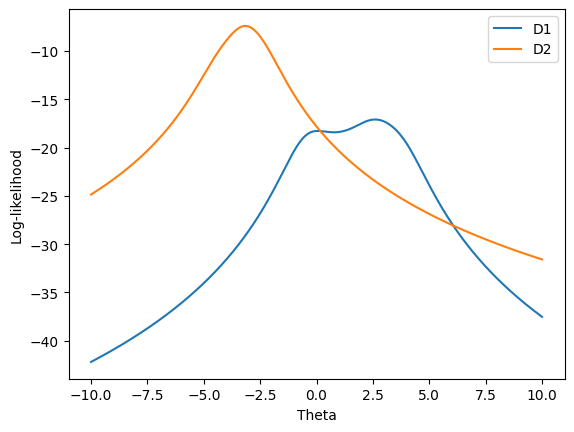

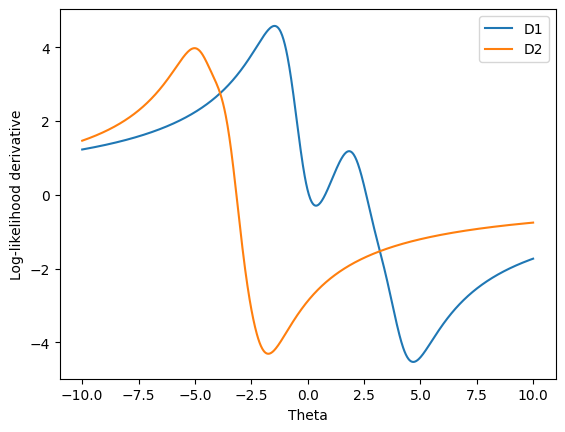

In [22]:
import numpy as np

d_1 = [2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1]
d_2 = [-4.5, -3.4, -3.1, -3.0, -2.3]

theta = np.linspace(-10, 10, 1000)

# Fit the classifier to the datasets
classifier = Classifier()
theta_1, theta_2 = classifier.fit(d_1, d_2, solve_method='numeric')
print(f"Theta for d_1: {theta_1}")
print(f"Theta for d_2: {theta_2}")

# Plots
plot_log_likelihood(d_1, d_2, theta)
# Plot the derivative of the log-likelihood functions, 
# so we can chse a good starting point for solving the derivative.
plot_log_likelihood_derivative(d_1, d_2, theta)

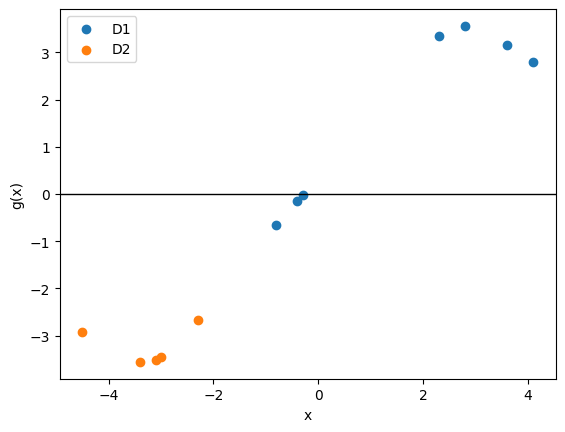

In [ ]:
d_1 = [2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1]
d_2 = [-4.5, -3.4, -3.1, -3.0, -2.3]

# Maximum likelihood thetas taken from the first part
theta_1 = 2.599795610944729
theta_2 = -3.158576677026769

# Compute the priors proportionally to the number of samples in each dataset
prior_1 = len(d_1) / (len(d_1) + len(d_2))
prior_2 = len(d_2) / (len(d_1) + len(d_2))

classifier = Classifier()

g_values_d_1 = classifier.predict(d_1, theta_1, theta_2, prior_1, prior_2)
g_values_d_2 = classifier.predict(d_2, theta_1, theta_2, prior_1, prior_2)
predicted_classes_d_1 = np.where(g_values_d_1 >= 0, 1, 2)
predicted_classes_d_2 = np.where(g_values_d_2 >= 0, 1, 2)

# Plot the g values
plt.figure()
plt.scatter(d_1, g_values_d_1, label="D1")
plt.scatter(d_2, g_values_d_2, label="D2")
plt.axhline(0, color='black', lw=1)
plt.xlabel("x")
plt.ylabel("g(x)")
plt.legend()
plt.show()
